# 时间序列
## 语言
python

## 库
statsmodels

# 程序执行


## 加载库

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math
import os
import copy

plt.rcParams['font.family'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False

## 读取所有数据


data目录下xlsx


In [2]:
path = './data/'
arr = []
for file in os.listdir(path):
    df = pd.read_excel('%s/%s' % (path, file))
    house = df[df['用　　途']=='普通住宅']
    arr.append(house)
df = pd.concat(arr)

## 公共方法


1. 新建表按照"总量"和各个区

In [3]:
def getAllFrame(df, freq):
    """
    获得全部框架
    :param df:  原始dataframe
    :param freq:    频率:天(1D),周(1W),半月(SM),月(1M)
    :return:    dataframe
    """
    combination = pd.Grouper(key='成交时间', freq=freq, origin='2020-01-01')
    total = df.groupby(combination).agg({'成交单价': 'count'})
    total.columns = ['总量']

    zones = df.groupby(['所在区县'])
    alldf = copy.deepcopy(total)
    for name, group in zones:
        zone = group.groupby(combination).agg({'成交单价': 'count'})
        zone.columns = [name]
        alldf = alldf.join(zone)
    alldf

    return alldf

2. 单位根检验（Dickey-Fuller test）

In [4]:
def dickey(df):
    """
    获得全部框架
    :param df:  原始dataframe
    :param freq:    频率:天(1D),周(1W),半月(SM),月(1M)
    :return:    dataframe
    """
    t = adfuller(df)
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    return output

## 总数dataframe

# 按照各种频率
1. 月
2. 半月
3. 周
4. 日

In [5]:
monthdf = getAllFrame(df, 'MS')
semidf = getAllFrame(df, 'SMS')
weekdf = getAllFrame(df, 'W')
daydf = getAllFrame(df, 'D')

## 时间序列图表
### 总量图

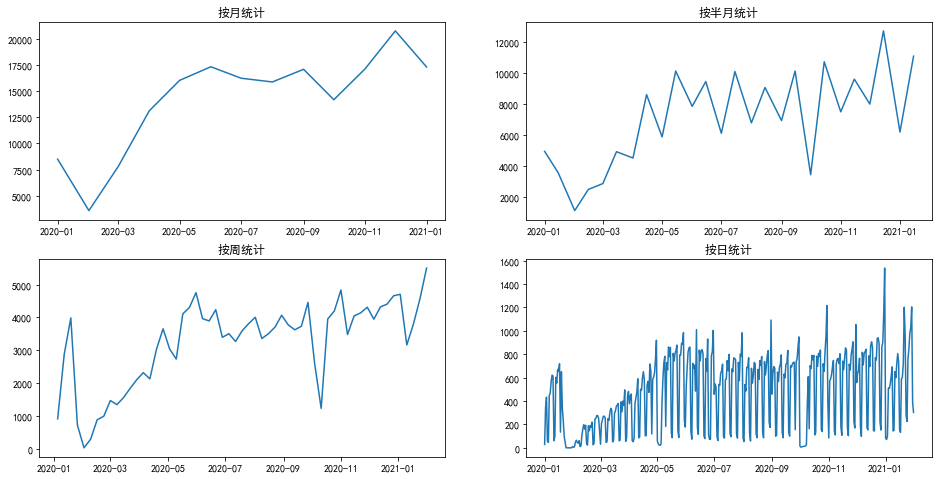

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes[0, 0].set_title('按月统计')
axes[0, 0].plot(monthdf['总量'])
axes[0, 1].set_title('按半月统计')
axes[0, 1].plot(semidf['总量'])
axes[1, 0].set_title('按周统计')
axes[1, 0].plot(weekdf['总量'])
axes[1, 1].set_title('按日统计')
axes[1, 1].plot(daydf['总量'])


### 按区分布

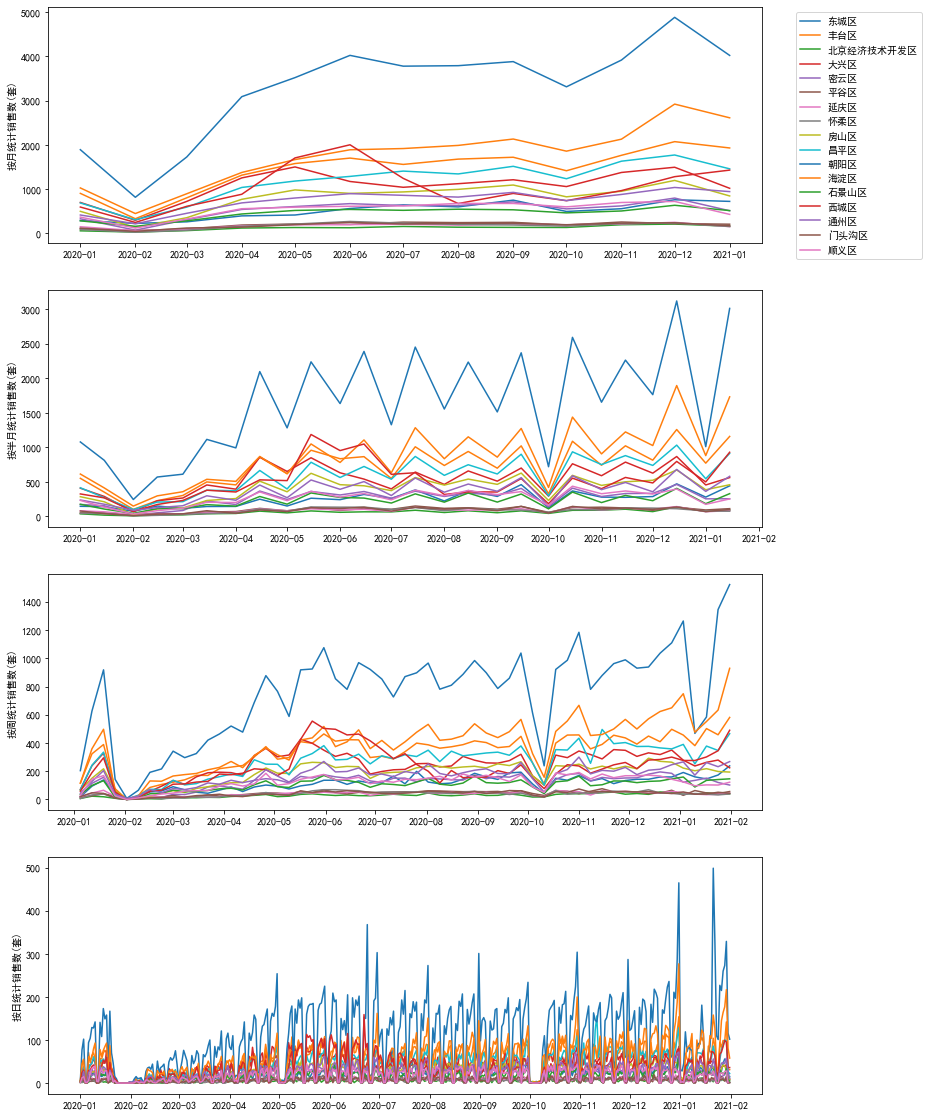

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(16, 20))
arr = [('按月统计', monthdf), ('按半月统计', semidf), ('按周统计', weekdf), ('按日统计', daydf)]
for index,data in enumerate(arr):
    df = data[1]
    for name in df.columns:
        if name != '总量':
            axes[index].plot(df[name], label=name)
    box = axes[index].get_position()
    axes[index].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axes[index].xaxis.set_major_locator(mdates.MonthLocator())
    axes[index].set_ylabel('%s销售数(套)' % data[0])
axes[0].legend( bbox_to_anchor=(1.04, 1))
plt.show()

## 单位根检验（Dickey-Fuller test）


p-value较高，序列具有单位根，即非平稳。

In [8]:
dickey(monthdf['总量'])

,value
Test Statistic Value,2.397828
p-value,0.999009
Lags Used,4
Number of Observations Used,8
Critical Value(1%),-4.665186
Critical Value(5%),-3.367187
Critical Value(10%),-2.802961


## ARMA(p,q)模型阶次


1. 我们通过观察PACF和ACF截尾，分别判断p、q的值。

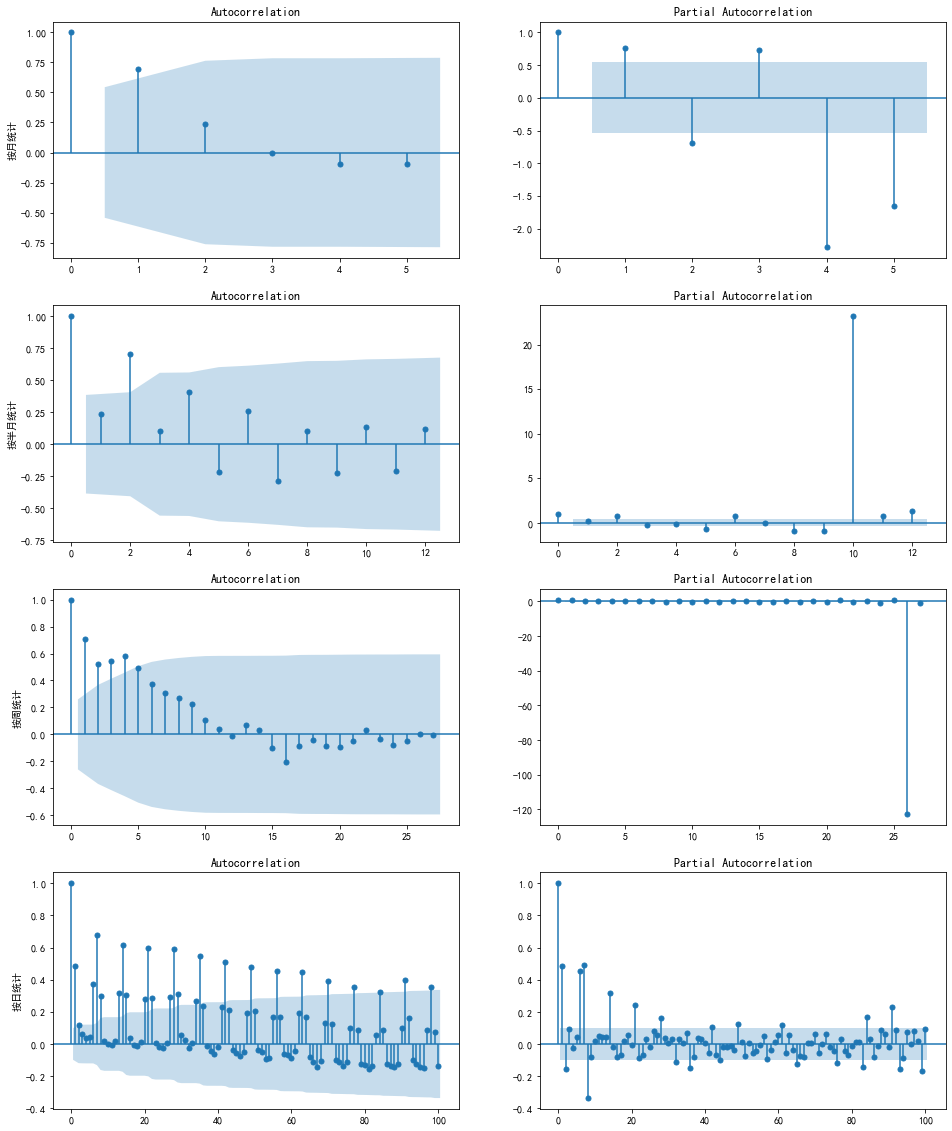

In [9]:
def showAcf():
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    arr = [('按月统计', monthdf), ('按半月统计', semidf), ('按周统计', weekdf), ('按日统计', daydf)]
    res = []
    for index,data in enumerate(arr):
        df = data[1]

        num = df.shape[0]
        # nlags = math.floor(num/2) - 1
        # if nlags > 20:
        #     nlags = 20
        # lag_acf = acf(df, nlags=nlags)
        # lag_pacf = pacf(df, nlags=nlags, method='ols')

        lags = math.floor(num/2) - 1
        if lags > 100:
            lags = 100
        plot_acf(df['总量'], lags=lags, ax=axes[index, 0])
        plot_pacf(df['总量'], lags=lags, ax=axes[index, 1])

        axes[index, 0].set_ylabel(data[0])
    plt.show()
showAcf()

## ARMA建模及预测


定阶(order)之后就能构建ARMA模型了

# 按月

In [10]:
order = (1,0)
model = ARMA(monthdf['总量'], order).fit()
model.summary()
# model.predict(start='2020-01', end='2021-01')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     总量   No. Observations:                   13
Model:                     ARMA(1, 0)   Log Likelihood                -123.032
Method:                       css-mle   S.D. of innovations           3018.742
Date:                Mon, 01 Feb 2021   AIC                            252.064
Time:                        19:02:46   BIC                            253.759
Sample:                    01-01-2020   HQIC                           251.715
                         - 01-01-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.379e+04   2827.124      4.879      0.000    8251.395    1.93e+04
ar.L1.总量       0.7550      0.172      4.392      0.000       0.418       1.092
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3245           +0.0000j            1.3245            0.0000
-----------------------------------------------------------------------------
"""

计算模型中系数的置信区间


残差序列的纯随机性的检验


自相关系数


单位根检验

In [11]:
model.conf_int()

,0,1
const,8251.394995,19333.518753
ar.L1.总量,0.418049,1.091912


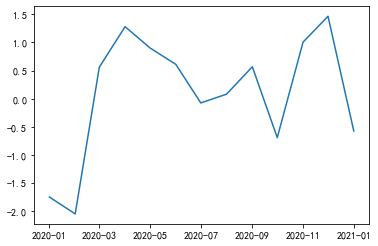

In [12]:
stdresid = model.resid / math.sqrt(model.sigma2)
plt.plot(stdresid)

# 半月

In [13]:
sm.tsa.arma_order_select_ic(semidf['总量'], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'aic':             0           1           2           3           4
 0         NaN  530.944701  514.495127  508.438702  500.202641
 1  504.189891  491.289595  483.278031  480.309938  482.264320
 2  478.407006  478.627576  478.558340  479.666624  477.675198
 3  479.889999  478.994082  483.898364  481.466265         NaN
 4  481.432412  479.448932  477.858513  474.891403  475.002785,
 'bic':             0           1           2           3           4
 0         NaN  533.460894  518.269417  513.471089  506.493123
 1  506.706084  495.063885  488.310417  486.600421  489.812899
 2  482.181296  483.659962  484.848823  487.215203  486.481874
 3  484.922385  485.284564  491.446943  490.272941         NaN
 4  487.722895  486.997511  486.665189  484.956176  486.325654,
 'aic_min_order': (4, 3),
 'bic_min_order': (2, 0)}

In [14]:
order = (2,0)
model = ARMA(semidf['总量'], order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     总量   No. Observations:                   26
Model:                     ARMA(2, 0)   Log Likelihood                -234.326
Method:                       css-mle   S.D. of innovations           1923.224
Date:                Mon, 01 Feb 2021   AIC                            476.652
Time:                        19:02:50   BIC                            481.685
Sample:                    01-01-2020   HQIC                           478.102
                         - 01-15-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6882.6452   1526.605      4.508      0.000    3890.554    9874.736
ar.L1.总量       0.0635      0.122      0.521      0.602      -0.175       0.302
ar.L2.总量       0.7412      0.125      5.915      0.000       0.496       0.987
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1195           +0.0000j            1.1195            0.0000
AR.2           -1.2052           +0.0000j            1.2052            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
model.conf_int()

,0,1
const,3890.554187,9874.736232
ar.L1.总量,-0.175452,0.302452
ar.L2.总量,0.495565,0.986787


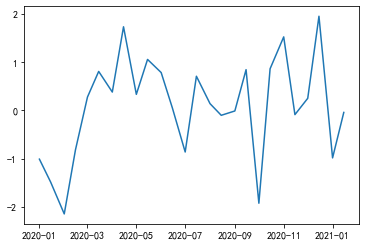

In [16]:
stdresid = model.resid / math.sqrt(model.sigma2)
plt.plot(stdresid)

# 按周

In [17]:
sm.tsa.arma_order_select_ic(weekdf['总量'], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'aic':             0            1            2           3           4
 0         NaN  1033.407993  1000.437122  982.068473  979.460856
 1  941.721646   941.525360   935.263430  937.020308  935.259577
 2  943.538196   943.504208   939.153645  937.854769  937.040271
 3  936.963599   934.254932   935.319132  936.317849  936.598937
 4  932.134442   934.133739   936.127908  937.938432  935.973771,
 'bic':             0            1            2           3           4
 0         NaN  1037.494095  1006.566275  990.240678  989.676112
 1  945.807749   947.654514   943.435635  947.235564  947.517885
 2  949.667350   951.676413   949.368902  950.113077  951.341630
 3  945.135804   944.470188   947.577439  950.619208  952.943347
 4  942.349699   946.392047   950.429267  954.282842  954.361232,
 'aic_min_order': (4, 0),
 'bic_min_order': (4, 0)}

In [18]:
order = (4,0)
model = ARMA(weekdf['总量'], order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     总量   No. Observations:                   57
Model:                     ARMA(4, 0)   Log Likelihood                -459.531
Method:                       css-mle   S.D. of innovations            754.729
Date:                Mon, 01 Feb 2021   AIC                            931.062
Time:                        19:02:56   BIC                            943.320
Sample:                    01-05-2020   HQIC                           935.826
                         - 01-31-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3206.8212    780.471      4.109      0.000    1677.125    4736.517
ar.L1.总量       0.7158      0.130      5.522      0.000       0.462       0.970
ar.L2.总量      -0.2287      0.158     -1.448      0.148      -0.538       0.081
ar.L3.总量       0.0462      0.179      0.258      0.796      -0.304       0.396
ar.L4.总量       0.3671      0.150      2.453      0.014       0.074       0.660
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0505           -0.0000j            1.0505           -0.0000
AR.2            0.2655           -1.2035j            1.2325           -0.2154
AR.3            0.2655           +1.2035j            1.2325            0.2154
AR.4           -1.7072           -0.0000j            1.7072           -0.5000
-----------------------------------------------------------------------------
"""

In [19]:
model.conf_int()

,0,1
const,1677.125414,4736.516969
ar.L1.总量,0.461718,0.969869
ar.L2.总量,-0.538252,0.080789
ar.L3.总量,-0.304003,0.396362
ar.L4.总量,0.073735,0.660434


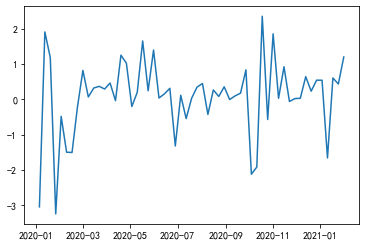

In [20]:
stdresid = model.resid / math.sqrt(model.sigma2)
plt.plot(stdresid)

# 按日

In [21]:
sm.tsa.arma_order_select_ic(daydf['总量'], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'aic':              0            1            2            3            4
 0          NaN  5883.387556  5785.838705  5740.779703  5684.633323
 1  5695.092759  5648.636829  5578.180388  5580.164411  5563.495134
 2  5695.366747  5598.711572  5580.170834  5577.518202  5564.710031
 3  5666.020485  5582.801724  5577.361521  5552.353005  5534.356238
 4  5661.536328  5573.850963  5570.240652  5513.273813  5506.516032,
 'bic':              0            1            2            3            4
 0          NaN  5891.355429  5797.790514  5756.715448  5704.553004
 1  5703.060632  5660.588638  5594.116133  5600.084092  5587.398752
 2  5707.318555  5614.647317  5600.090516  5601.421819  5592.597585
 3  5681.956230  5602.721405  5601.265139  5580.240559  5566.227729
 4  5681.456009  5597.754581  5598.128206  5545.145303  5542.371459,
 'aic_min_order': (4, 4),
 'bic_min_order': (4, 4)}

In [22]:
order = (4,4)
model = ARMA(daydf['总量'], order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     总量   No. Observations:                  397
Model:                     ARMA(4, 4)   Log Likelihood               -2718.193
Method:                       css-mle   S.D. of innovations            226.177
Date:                Mon, 01 Feb 2021   AIC                           5456.385
Time:                        19:03:24   BIC                           5496.225
Sample:                    01-01-2020   HQIC                          5472.167
                         - 01-31-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        464.9277     19.221     24.188      0.000     427.255     502.601
ar.L1.总量       0.5413      0.068      7.953      0.000       0.408       0.675
ar.L2.总量      -1.2479      0.041    -30.707      0.000      -1.328      -1.168
ar.L3.总量       0.6774      0.051     13.215      0.000       0.577       0.778
ar.L4.总量      -0.6887      0.058    -11.890      0.000      -0.802      -0.575
ma.L1.总量       0.0045      0.073      0.061      0.951      -0.139       0.148
ma.L2.总量       1.4175      0.057     24.744      0.000       1.305       1.530
ma.L3.总量      -0.1235      0.075     -1.645      0.100      -0.271       0.024
ma.L4.总量       0.6113      0.051     11.909      0.000       0.511       0.712
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2234           -0.9758j            1.0011           -0.2858
AR.2           -0.2234           +0.9758j            1.0011            0.2858
AR.3            0.7152           -0.9682j            1.2037           -0.1487
AR.4            0.7152           +0.9682j            1.2037            0.1487
MA.1           -0.2221           -1.0027j            1.0270           -0.2847
MA.2           -0.2221           +1.0027j            1.0270            0.2847
MA.3            0.3231           -1.2027j            1.2454           -0.2082
MA.4            0.3231           +1.2027j            1.2454            0.2082
-----------------------------------------------------------------------------
"""

In [23]:
model.conf_int()

,0,1
const,427.254529,502.600964
ar.L1.总量,0.407906,0.674730
ar.L2.总量,-1.327591,-1.168285
ar.L3.总量,0.576905,0.777829
ar.L4.总量,-0.802217,-0.575167
ma.L1.总量,-0.139336,0.148340
ma.L2.总量,1.305213,1.529776
ma.L3.总量,-0.270631,0.023608
ma.L4.总量,0.510726,0.711962


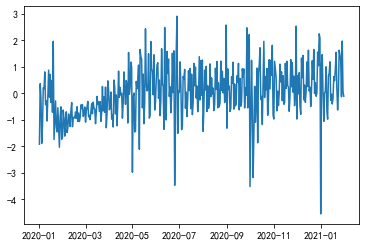

In [24]:
stdresid = model.resid / math.sqrt(model.sigma2)
plt.plot(stdresid)